In [1]:
import camb
import numpy as np
%pylab inline
import matplotlib.pyplot as plt
from camb import model
from scipy import special
from sympy.functions import coth

class CosmoParams:
    def __init__(self,         #default is WMAP9
                 om=0.279,ol=0.721,h0=70.0,s8=0.821,ns=0.972,
                 ob=0.0463,r=0.0,mnu=0.00,tau=0.08,**options):

        h100 = 100. 
        self.rho_crit0 = 3. / (8 * np.pi) * (h100 * 1e5)**2 / c.G_CGS * c.MPC2CM / c.MSUN_CGS

        self.om = om
        self.ol = ol
        self.h0 = h0
        self.s8 = s8
        self.ns = ns
        self.ob = ob
        self.r = r
        self.mnu = mnu
        self.tau = tau
            
        if options.get("Param") == 'Planck15':
            self.om = 0.315
            self.ol = 0.685
            self.h0 = 67.31
            self.s8 = 0.829
            self.ns = 0.9655
            self.ob = 0.04904
            self.r = 0.0
            self.mnu = 0.00
            self.tau = 0.08
                
        if options.get("Param") == 'Tinker':
            self.om = 0.30
            self.ol = 0.70
            self.h0 = 70
            self.s8 = 0.9
            self.ns = 1.0
            self.ob = 0.04
            self.r = 0.0
            self.mnu = 0.00
            self.tau = 0.08
            
        if options.get("Param") == 'JB':
            self.om = 0.30
            self.ol = 0.70
            self.h0 = 70
            self.s8 = 0.98
            self.ns = 1.0
            self.ob = 0.04
            self.r = 0.0
            self.mnu = 0.00
            self.tau = 0.17
            
class Constants:
    def __init__(self):
        self.ERRTOL = 1e-12
        self.G_CGS = 6.67259e-08
        self.MSUN_CGS = 1.98900e+33
        self.MPC2CM = 3.085678e+24
        self.SIGMA_T = 6.65246e-25 #cgs
        self.ME = 9.10939E-28
        self.C = 2.99792e+10
        self.K_CGS = 1.3806488e-16
        self.H_CGS = 6.62608e-27
        self.TCMB = 2.726
        self.eV_2_erg = 1.60217662e-12
        
class Halo_tools:
    def __init__(self):
        pass
    
    #NFW cumulative mass distribution
    def m_x(self,x):
        ans = np.log(1 + x) - x/(1+x)
        return ans
    #hubble function
    def E_z(self,z):
        ans = np.sqrt(cp.om * (1 + z)**3 + cp.ol)
        return ans
    #critical density as a function of z
    def rhoc(self,z):
        ans = cp.rho_crit0*self.E_z(z)**2
        return ans
    
    #spherical overdensity radius w.r.t. the critical density
    def rdel_c(self,M,z,delta):
        ans = (3 * M / (4 * np.pi * delta*self.rhoc(z)))**(1.0/3.0)
        return ans
    
    #spherical overdensity radius w.r.t. the mean matter density
    def rdel_m(self,M,z,delta):
        ans = (3 * M / (4 * np.pi * delta*cp.rho_crit0*cp.om*(1.+z)**3))**(1.0/3.0) 
        return ans

    #Seljak 2000 with hs in units
    def con_M_rel_seljak(self,Mvir, z):
        ans = 5.72 / (1 + z) * (Mvir / 10**14)**(-0.2)
        return ans
    
    #Duffy 2008 with hs in units
    def con_M_rel_duffy(self,Mvir, z):
        ans = 5.09 / (1 + z)**0.71 * (Mvir / 10**14)**(-0.081)
        return ans
        
    #Duffy 2008 with hs in units MEAN DENSITY 200
    def con_M_rel_duffy200(self,Mvir, z):
        ans = 10.14 / (1 + z)**(1.01) * (Mvir / 2e12)**(-0.081)
        return ans
   
    #Mass conversion critical to mean overdensity, needed because the Tinker Mass function uses mean matter
    def Mass_con_del_2_del_mean200(self,Mdel,delta,z):
        Mass = 2.*Mdel
        rdels = self.rdel_c(Mdel,z,delta)
        ans = Mass*0.0
        for i in xrange(np.size(Mdel)):
            while np.abs(ans[i]/Mass[i] - 1) > c.ERRTOL : 
                ans[i] = Mass[i]
                conz = self.con_M_rel_duffy200(Mass[i],z) #DUFFY
                rs = self.rdel_m(Mass[i],z,200)/conz
                xx = rdels[i] / rs
                Mass[i] = Mdel[i] * self.m_x(conz) / self.m_x(xx)
        ## Finish when they Converge
        return ans
    
class Halo_MF:
    def __init__(self):
        pass
    
    #Using CAMB to get p of k
    def pk(self,z_arr):
        
        #print('Using CAMB installed at '+ os.path.realpath(os.path.join(os.getcwd(),'..')))
        sys.path.insert(0,os.path.realpath(os.path.join(os.getcwd(),'..')))
        pars = camb.CAMBparams()
        pars.set_cosmology(H0=cp.h0, ombh2=cp.ob*(cp.h0/100.)**2, omch2=(cp.om - cp.ob)*(cp.h0/100.)**2, \
                           mnu=cp.mnu , tau=cp.tau)
        
        pars.InitPower.set_params(ns=cp.ns, r=cp.r)
        
        pars = camb.CAMBparams()
        pars.set_cosmology(H0=cp.h0, ombh2=cp.ob*(cp.h0/100.)**2, omch2=(cp.om - cp.ob)*(cp.h0/100.)**2,)    
        pars.set_dark_energy() #re-set defaults
        pars.InitPower.set_params(As=2.19e-9,ns=cp.ns)
        
        pars.set_matter_power(redshifts=z_arr, kmax=11.0)
        pars.Transfer.high_precision = True
        
        pars.NonLinear = model.NonLinear_none
        results = camb.get_results(pars)
        kh2, z2, pk2 = results.get_matter_power_spectrum(minkh=2e-5, maxkh=11, npoints = 200,)
        s8 = np.array(results.get_sigma8())
        return kh2, z2, pk2, s8
    
    def Halo_Tinker_test(self):
        
        #define parameters delta, M and z
        z_arr = np.array([0,0.8,1.6])
        M = 10**np.arange(10., 16, .1)
        delts = z_arr*0 + 200.
        delts_8 = z_arr*0 + 800.
        delts_32 = z_arr*0 + 3200.
    
        # start timer
        start = time.clock()
        
        #get p of k and s8 
        kh, z, pk, s8 = HMF.pk(z_arr)
        # dn_dlogM from tinker
        N = dn_dlogM(M,z_arr,cp.rho_crit0*cp.om,delts,kh,pk[:1,:])
        N_8 = dn_dlogM(M,z_arr,cp.rho_crit0*cp.om,delts_8,kh,pk[:1,:])
        N_32 = dn_dlogM(M,z_arr,cp.rho_crit0*cp.om,delts_32,kh,pk[:1,:])
        
        elapsed1 = (time.clock() - start)
        #print elapsed1 
        
        #plot tinker values
        f = figure(figsize=(8,8))
        plt.ylim([-3.6,-0.8])
        plt.plot(np.log10(M),np.log10(N[:,0]*M/(cp.rho_crit0*cp.om)),'k')
        plt.plot(np.log10(M),np.log10(N_8[:,0]*M/(cp.rho_crit0*cp.om)),'k')
        plt.plot(np.log10(M),np.log10(N_32[:,0]*M/(cp.rho_crit0*cp.om)),'k')
        
        return f
    
    def dVdz(self,z_arr):
        pars = camb.CAMBparams()
        pars.set_cosmology(H0=cp.h0, ombh2=cp.ob*(cp.h0/100.)**2, omch2=(cp.om - cp.ob)*(cp.h0/100.)**2,)    
        results = camb.get_background(pars)
        DA_z = results.angular_diameter_distance(z_arr)
        dV_dz = DA_z**2 * (1.+z_arr)**2
        for i in xrange (len(z_arr)):
            dV_dz[i] /= (results.h_of_z(z_arr[i]))
        #print (results.h_of_z(z_arr[i])),z_arr[i],100. * 1e5/2.99792458e10*hh
        dV_dz *= (cp.h0/100.)**3
        return dV_dz

    def dn_dM(self,M,z_arr,delta):
        
        delts = z_arr*0 + delta
        kh, z, pk, s8 = HMF.pk(z_arr)
        fac = (cp.s8/s8[-1])**2 # sigma8 values are in reverse order
        pk *= fac
    
        dn_dlnm = dn_dlogM(M,z_arr,cp.rho_crit0*cp.om,delts,kh,pk[:,:],'comoving')
        dn_dm = dn_dlnm/M
        return dn_dm
    
    def N_of_Mz(self,M,z_arr,delta):
        
        delts = z_arr*0 + delta
        kh, z, pk, s8 = HMF.pk(z_arr)
        fac = (cp.s8/s8[-1])**2 # sigma8 values are in reverse order
        pk *= fac
    
        dn_dlnm = dn_dlogM(M,z_arr,cp.rho_crit0*cp.om,delts,kh,pk[:,:],'comoving')
        dn_dm = dn_dlnm/M
        dV_dz = self.dVdz(z_arr)
        
        N_dzdm = dn_dm[:,1:] * dV_dz[1:] * 4*np.pi
        return N_dzdm

Populating the interactive namespace from numpy and matplotlib


In [79]:
class SZ_Cluster_Model:
    def __init__(self,P0=8.403,xc=1.177,al=1.05,gm=0.31,bt=5.49,fwhm=1,rms_noise =1,**options):
        self.P0 = P0
        self.xc = xc
        self.al = al
        self.gm = gm
        self.bt = bt
        self.fwhm = fwhm
        self.rms_noise = rms_noise
        
        self.NNR = 1000
        self.drint = 1e-4
        if options.get("Model") == 'BBPS':
            self.P0 = 7.49
            self.xc = 0.710
            self.al = 1.0
            self.gm = -0.3
            self.bt = 4.19
    
    def f_nu(self,nu):
        mu = c.H_CGS*(1e9*nu)/(c.K_CGS*c.TCMB)
        ans = mu*coth(mu/2.0) - 4.0
        return np.float(ans)
    
    def GNFW(self,xx,**options):
        ans = self.P0 / ((xx*self.xc)**self.gm * (1 + (xx*self.xc)**self.al)**((self.bt-self.gm)/self.al))
        if options.get("Model") == 'BBPS':
            ans = self.P0 * (xx/self.xc)**self.gm / (1 + (xx/self.xc)**self.al)**self.bt
        return ans
    
    def Prof(self,r,M,z):
        R500 = HP.rdel_c(M,z,500)
        xx = r / R500
        M_fac = M / (3e14) * (100./70.)
        P500 = 1.65e-3 * (100./70.)**2 * M_fac**(2./3.) * HP.E_z(z) #keV cm^3
        ans = P500 * self.GNFW(xx)
        return ans
    
    def y2D_norm(self,tht):
        M = 1e14 #FIX
        z = 0.01 #FIX
        #tht = xx
        R500 = HP.rdel_c(M,z,500)
        rad = (np.arange(1e5) + 1.0)*self.drint #in MPC (max rad is 10 MPC)

        #dtht = 5./self.NNR
        #thta = np.deg2rad(np.arange(0,50.,dtht))
        P2D = tht * 0.0
        for ii in xrange(len(tht)):
            rint = np.sqrt((rad)**2 + tht[ii]**2*(R500)**2)
            P2D[ii] = np.sum(2.*self.Prof(rint,M,z)*self.drint)
        P2D /= P2D[0]
        y2D_out = P2D #np.interp(tht,thta,P2D,right=0)
        return y2D_out
        
    def y2D_tilde_norm(self,k,thtc):
        dtht = 0.00001
        thta = np.arange(dtht,100*thtc,dtht) / thtc
        ans = k*0.
        y2D_use = self.y2D_norm(thta)
        for ii in xrange(len(k)):
            ans[ii] = np.sum(thta*special.jv(0,k[ii]*thta)*y2D_use)*dtht
        return ans/thtc
    
    def y2D_test(self,tht,thtc):
        ans = (1. + (tht/thtc)**2)**(-0.5) # beta profile beta = 2/3
        return ans

    def y2D_tilde_test(self,k,thtc):
        #thtc = 1. / 60. / (180./np.pi) # rads 
        dtht = 0.00001
        thta = np.arange(dtht,100*thtc,dtht)
        ans = k*0.
        y2D_use = self.y2D_test(thta,thtc)
        for ii in xrange(len(k)):
            ans[ii] = np.sum(thta*special.jv(0,k[ii]*thta/thtc)*y2D_use)*dtht
        return ans/thtc**2

    def noise_func(self,ell):
        
        rms = self.rms_noise * (1./60.)*(np.pi/180.)
        tht_fwhm = np.deg2rad(self.fwhm / 60.)
        
        ans = rms**2 * np.exp(tht_fwhm**2*ell**2 / (8.*np.log(2)))
        return ans
    
    def tot_noise_spec(self):
        #spec_file = "/Users/nab/CAMB/test_lensedCls_new.dat"
        spec_file = "/Users/nab/CAMB/test_scalCls_new.dat"
        ell,cl = np.loadtxt(spec_file,usecols=[0,1],unpack=True)
        ell_extra = np.arange(60000)+np.max(ell)+1.
        cll_extra = np.zeros(60000)
        ell = np.append(ell,ell_extra)
        cl = np.append(cl,cll_extra) *np.pi/(ell*(ell+1.)) 
        
        cltot = cl + self.noise_func(ell)
        return ell,cltot,cl

    def plot_noise(self):
        el,nl,cl = self.tot_noise_spec()
        
        f = figure(figsize=(6,6))
        plt.xlim([60,8e3])
        plt.ylim([1e-2,1e5])
        plt.loglog(el,nl*el**2)
        plt.plot(el,SZProf.noise_func(el)*el**2)
        plt.plot(el,cl*el**2)
        
        return f
    
    def tot_noise_spec_k(self,k):
        el,nl,cl = self.tot_noise_spec()
        pars = camb.CAMBparams()
        pars.set_cosmology(H0=cp.h0, ombh2=cp.ob*(cp.h0/100.)**2, omch2=(cp.om - cp.ob)*(cp.h0/100.)**2,)    
        results = camb.get_background(pars)
        DA_z = results.angular_diameter_distance(1100.) * (cp.h0/100.)
        #print DA_z
        k_2_el = k*DA_z*(1101.)/np.pi
        nl_out = np.interp(k_2_el,el,nl)
        return nl_out

    
    def filter_variance(self,thtc): #FIX
        dtht = 0.000001
        tht = np.arange(dtht,10*thtc,dtht)
        dk = 0.001
        kk = np.arange(0,10,dk)
        freq_fac = (self.f_nu(15.))**2 ##AMI like
        prof_int = 2.*np.pi*np.sum(self.y2D_norm(tht,thtc)*tht)*dtht#/thtc**2
        print prof_int,freq_fac
        var = np.sum(kk*self.y2D_tilde_test(kk,thtc)**2/self.tot_noise_spec_k(kk))*dk 
        return prof_int / np.sqrt(var) / np.sqrt(freq_fac)

c = Constants()
HP = Halo_tools()
cp = CosmoParams()
SZProf = SZ_Cluster_Model(rms_noise = 12.,fwhm=1.5 )

thetc =  0.00171624043113


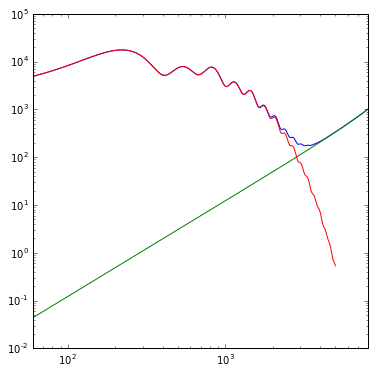

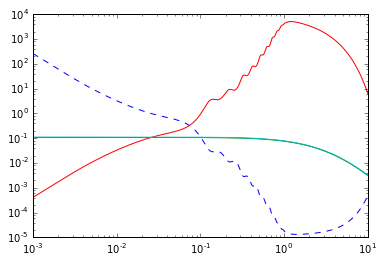

In [80]:

noise_plot = SZProf.plot_noise()
noise_plot.show()

dk = 0.001
ktest = np.arange(0,10,dk)
#ktest = 10**(np.arange(-3.5,1.0,0.1))

arc = 5.9

thetc = np.deg2rad(arc / 60.)
thetc2 = np.deg2rad(arc/2. / 60.)
print "thetc = ", thetc

nl_k = SZProf.tot_noise_spec_k(ktest)
y2dt2= SZProf.y2D_tilde_norm(ktest,thetc)
y2dt2_2= SZProf.y2D_tilde_norm(ktest,thetc2)

plt.figure()
plt.plot(ktest,nl_k,'--')
plt.loglog(ktest,y2dt2)
plt.plot(ktest,y2dt2/nl_k)
plt.loglog(ktest,y2dt2_2)

#FIX
#fvar = SZProf.filter_variance(thetc)
#print fvar #UNITS!!!!!!! [armin2] dropped a deg to arcmin somewhere
#print fvar * thetc**2


dthttest = np.deg2rad(0.1/60)
tht = np.arange(dthttest,60*5*dthttest,dthttest)/thetc
#tht2 = tht/2.0
#dthttest = 0.00001*arc
#tht = np.arange(dthttest,0.05*arc,dthttest)
filt = 0.0*tht
filt2 = 0.0*tht
for ii in xrange(len(tht)):
    filt[ii] = np.sum(special.jv(0,ktest*tht[ii])*ktest*y2dt2/nl_k)*dk
    filt2[ii] = np.sum(special.jv(0,ktest*tht[ii])*ktest*y2dt2_2/nl_k)*dk

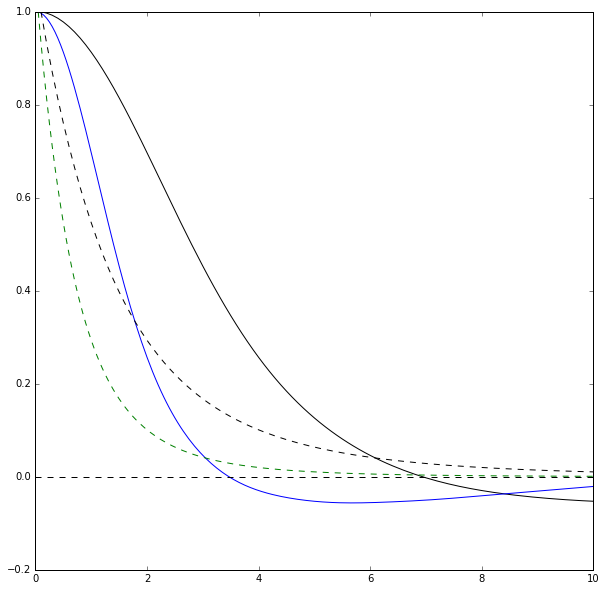

In [81]:
#plt.figure()
#plt.loglog(ktest,y2dt2/y2dt2_2)

#print y2dt2/y2dt2_2
fig = plt.figure(figsize=(10,10))
plt.xlim([0,10])
#plt.plot(tht/thetc,filt/np.max(filt))
plt.plot(np.rad2deg(tht*thetc)*60.,filt/np.max(filt),'k')
plt.plot(np.rad2deg(tht*thetc2)*60.,filt2/np.max(filt2))
plt.plot(np.rad2deg(tht*thetc)*60.,SZProf.y2D_norm(tht),'k--')
plt.plot(np.rad2deg(tht*thetc2)*60.,SZProf.y2D_norm(tht),'--')
#plt.plot(np.rad2deg(tht)*60.,SZProf.y2D_test(tht,thetc),'--')
plt.plot([0,10],[0,0],'k--')
#xx,yy = np.loadtxt('/Users/nab/Desktop/Projects/Match_filter/JBM_2005.dat',unpack=True)
#plt.plot(xx,yy,'rx')

2.94548121744e-06
9.0
1.20994338299e-08
0.00673705140962
0.00112436468372


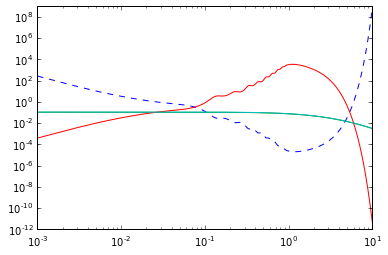

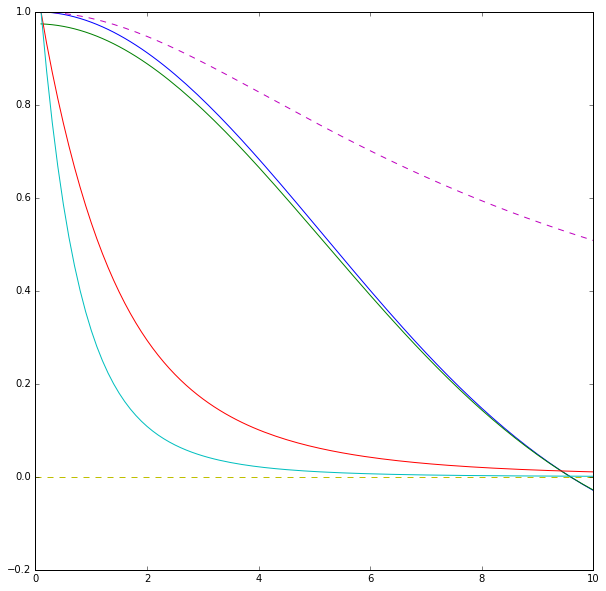

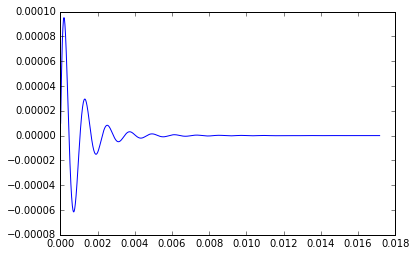

In [50]:
dtht = 0.00001
thta = np.arange(dtht,10*thetc,dtht)
ans = ktest
y2D_use = SZProf.y2D_norm(thta/thetc)
#for ii in xrange(len(k)):
ii = 9000
print ktest[ii]
figure()
plt.plot(thta,thta*special.jv(0,ktest[ii]*thta/thetc)*y2D_use)
#ans[ii] = np.sum(tht*special.jv(0,k[ii]*thta/thtc)*y2D_use)*dtht

print np.sum(thta*special.jv(0,ktest[ii]*thta/thetc)*y2D_use)*dtht

print 2*np.pi*np.sum(SZProf.y2D_norm(tht/thetc)*tht)*dthttest * (180. / np.pi)**2
print 3.42501068855e-07 * (180. / np.pi)**2